# Batch process
# PENDING

Reginaldo K Fukuchi 

This NB batch process the subjects in the dataset RIC and RBDS

RBDS Lab Coordinate system
*       X - points to the driection of walking
*       Y - points vertically upwards
*       Z - points to the subject's right

RIC the following Lab Coordinate system
*       X - points to the subject's right
*       Y - points vertically upwards
*       Z - points opposite of the walking direction

%% NOTE the Segment coordinate systems
*       X - Anterior .....................................[AB / AD duction]
*       Y - Vertically upwards ............................[Axial rotation]
*       Z - points to the subject's right side ...[Hinge flexion extension]

In [1]:
# Prepare environment
import os, glob, sys
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import signal
import scipy.io as spio
from tqdm.notebook import tqdm

%matplotlib inline

from detecta import detect_peaks

import sys
sys.path.insert(1, r'../functions')

In [2]:
# File directories 
dir_data = r'../data' 
data_dir_RBDS = r'C:\Users\Reginaldo\Documents\data\CNPq\RBDS_v2\Figshare'
dir_csv_RIC   = r'C:\Users\Reginaldo\OneDrive - University of Calgary\data\Figshare_SciData\new_unzip'

# Get the best match subject from RIC dataset to compare with RBDS subjects

In [3]:
# Dataframe with metadata
info_RIC = pd.read_csv(os.path.join(dir_data,'run_data_meta.csv'))

In [4]:
# Dataframe with metadata
info_RBDS = pd.read_csv(os.path.join(dir_data,'RBDSinfo.txt'), delimiter='\t')
info_RBDS.drop_duplicates(subset='Subject', inplace=True)
info_RBDS = info_RBDS[info_RBDS['Gender']!='F'] # Exclude female subject

In [5]:
desc = info_RBDS[['Age','Height','Mass']].agg(['count', 'mean', 'std', 'min', 'max'])
desc

,Age,Height,Mass
count,27.000000,27.000000,27.000000
mean,34.592593,176.325926,70.111111
std,6.761084,6.646549,7.464175
min,22.000000,162.700000,57.050000
max,51.000000,187.200000,82.150000


## Filter RIC data to find the best match

In [6]:
# Remove female subjects
info_RIC = info_RIC[info_RIC['Gender']=='Male']

In [7]:
dev = 0.025 # 2.5%

In [8]:
uL_age = desc['Age']['mean']+desc['Age']['std']
lL_age = desc['Age']['mean']-desc['Age']['std']
print('Lower limit age criterion is '+str(lL_age)+' years')
print('Upper limit age criterion is '+str(uL_age)+' years')

Lower limit age criterion is 27.831509046869268 years
Upper limit age criterion is 41.35367613831592 years


In [9]:
uL_ht = desc['Height']['mean']+desc['Height']['std']
lL_ht = desc['Height']['mean']-desc['Height']['std']
print('Lower limit Height criterion is '+str(lL_ht)+' cm')
print('Upper limit Height criterion is '+str(uL_ht)+' cm')

Lower limit Height criterion is 169.6793772210258 cm
Upper limit Height criterion is 182.97247463082607 cm


In [10]:
uL_wt = desc['Mass']['mean']+desc['Mass']['std']
lL_wt = desc['Mass']['mean']-desc['Mass']['std']
print('Lower limit Mass criterion is '+str(lL_wt)+' kg')
print('Upper limit Mass criterion is '+str(uL_wt)+' kg')

Lower limit Mass criterion is 62.6469359888079 kg
Upper limit Mass criterion is 77.57528623341433 kg


In [11]:
uL_speed = 2.5 + 0.025*3.5
lL_speed = 2.5 - 0.025*3.5
print('Lower limit run speed criterion is '+str(lL_speed)+' m/s')
print('Upper limit run speed criterion is '+str(uL_speed)+' m/s')

Lower limit run speed criterion is 2.4125 m/s
Upper limit run speed criterion is 2.5875 m/s


In [12]:
speed_filt = info_RIC[(info_RIC['speed_r']<uL_speed) & (info_RIC['speed_r']>lL_speed)]
demo_filt  = speed_filt[(speed_filt['age']>lL_age) & (speed_filt['age']<uL_age)]
height_filt= demo_filt[(demo_filt['Height']<uL_ht) & (demo_filt['Height']>lL_ht)]

### Import support functions

In [13]:
import parse_gait_kinematics as parse_gait
import SCS_RIC as scs
import jointangles3d as jang3d
from gait_kinematics import gait_kinematics
from gait_steps import gait_steps
from gait3d_angles import gait3d_angles
from critic_damp import critic_damp
from svdt import svdt
from tnorma import tnorma

In [14]:
method = 'RIC'

In [15]:
if method=='RIC':
    # RIC list of subjects and files
    sub_ids = height_filt['sub_id'].tolist()
    fn_RIC  = height_filt['filename'].tolist()
    RIC_dir = r'C:\Users\Reginaldo\OneDrive - University of Calgary\data\Figshare_SciData\new_unzip'
else:
    # RBDS
    RBDS_dir = r'C:\Users\Reginaldo\Documents\data\CNPq\RBDS_v2\Figshare'
    fns_RBDS = glob.glob(os.path.join(RBDS_dir,'RBDS*static.c3d'))
    sub_ids = [subs[-17:-10] for subs in fns_RBDS]

### Batch process
* RBDS too about 8 minutes [08:07<00:00, 18.19s/it]

In [16]:
# Import JSON files
angsR2  = np.empty(shape=(101,15,len(sub_ids)))*np.NaN
angsL2  = np.empty(shape=(101,15,len(sub_ids)))*np.NaN
angsRall= np.empty(shape=(101,15,100,len(sub_ids)))*np.NaN
angsLall= np.empty(shape=(101,15,100,len(sub_ids)))*np.NaN
for s, subject in tqdm(enumerate(sub_ids), desc='Loading...', leave=True):
    if method=='RIC':
        # Running Injury Clinic data set
        fn_json=os.path.join(RIC_dir, str(sub_ids[s]), fn_RIC[s])
        neutral, joints, gait, hz = parse_gait.parse_RIC(fn_json)
    else:
        fn_static = os.path.join(RBDS_dir,subject+'static.c3d')
        fn_gait = os.path.join(RBDS_dir,subject+'runT25.c3d')
        neutral, joints, gait, hz = parse_gait.parse_RBDS(fn_static, fn_gait, filt=True)

    # Calculate joint angles
    virt_mkrs, angles = gait3d_angles(neutral, joints, gait)

    # Convert dict in arrays
    L_ankle_ang, R_ankle_ang = angles['L_ankle_ang'], angles['R_ankle_ang']
    L_knee_ang, R_knee_ang = angles['L_knee_ang'], angles['R_knee_ang']
    L_hip_ang, R_hip_ang = angles['L_hip_ang'], angles['R_hip_ang']
    L_foot_ang, R_foot_ang = angles['L_foot_ang'], angles['R_foot_ang']
    pelvis_ang = angles['pelvis_ang']

    # Convert angles in degrees
    L_ankle_ang, R_ankle_ang = L_ankle_ang * (180/np.pi), R_ankle_ang * (180/np.pi)
    L_knee_ang, R_knee_ang = L_knee_ang * (180/np.pi), R_knee_ang * (180/np.pi)
    L_hip_ang, R_hip_ang = L_hip_ang * (180/np.pi), R_hip_ang * (180/np.pi)
    L_foot_ang, R_foot_ang = L_foot_ang * (180/np.pi), R_foot_ang * (180/np.pi)
    pelvis_ang = pelvis_ang * (180/np.pi)

    # Structure the data to be input into gait_steps
    joints_lbls = ['pelvis','L_foot','R_foot','L_hip','R_hip','L_knee','R_knee',
                   'L_ankle','R_ankle']
    xyz = list('XYZ')*len(joints_lbls)
    joints_lbls = [ele for ele in joints_lbls for i in range(3)]
    joints_lbls = [joints_lbls[i]+'_'+xyz[i] for i in range(len(xyz))]

    # Create a pandas df with angles
    angs = np.hstack([pelvis_ang, L_foot_ang, R_foot_ang, 
                      L_hip_ang, R_hip_ang, L_knee_ang, R_knee_ang, 
                      L_ankle_ang, R_ankle_ang])
    angles = pd.DataFrame(data=angs, columns=joints_lbls)

    # Detect gait events using gait_steps.py
    L_TD_RIC, L_TO_RIC, R_TD_RIC, R_TO_RIC, eventsflag_RIC, label_RIC = gait_steps(neutral, gait, angles, hz)
    RTD_RIC, RTO_RIC = R_TD_RIC.astype(int).tolist(), R_TO_RIC.astype(int).tolist()
    LTD_RIC, LTO_RIC = L_TD_RIC.astype(int).tolist(), L_TO_RIC.astype(int).tolist()

    # Right side 
    anglesR = angles.loc[:, angles.columns.str.contains('|'.join(['R_', 'pelvis']))]
    angsR = np.empty(shape=(101,anglesR.shape[1],len(RTD_RIC)-1))
    for iR in range(len(RTD_RIC)-1):
        angsR[:,:,iR], tn, indie = tnorma(anglesR.values[RTD_RIC[iR]:RTD_RIC[iR+1],:], 
                                          k=1, smooth=0, mask=None, show=False)

    # Left side
    anglesL = angles.loc[:, angles.columns.str.contains('|'.join(['L_', 'pelvis']))]
    angsL = np.empty(shape=(101,anglesL.shape[1],len(LTD_RIC)-1))
    for iL in range(len(LTD_RIC)-1):
        angsL[:,:,iL], tn, indie = tnorma(anglesL.values[LTD_RIC[iL]:LTD_RIC[iL+1],:], 
                                          k=1, smooth=0, mask=None, show=False)
    # Store avg of each subject
    angsR2[:, :, s] = np.mean(angsR, axis=2)
    angsL2[:, :, s] = np.mean(angsL, axis=2)
    
    # Store all gait cycles
    angsRall[:,:,:len(RTD_RIC)-1,s] = angsR
    angsLall[:,:,:len(LTD_RIC)-1,s] = angsL
    #print(str(sub_ids[s])+ ' and ' + fn_RIC[s])

Loading...: 0it [00:00, ?it/s]

In [17]:
# np.save(os.path.join(dir_data, 'R_angs_'+method+'all.npy'), angsRall)
# np.save(os.path.join(dir_data, 'L_angs_'+method+'all.npy'), angsLall)
# np.save(os.path.join(dir_data, 'R_angs_'+method+'.npy'), angsR2)
# np.save(os.path.join(dir_data, 'L_angs_'+method+'.npy'), angsL2)

## Compare datasets

In [ ]:
# R_ang_RBDS = np.load(os.path.join(dir_data, 'R_angs_RBDS.npy'))
# R_ang_RIC  = np.load(os.path.join(dir_data, 'R_angs_RIC.npy'))
# L_ang_RBDS = np.load(os.path.join(dir_data, 'L_angs_RBDS.npy'))
# L_ang_RIC  = np.load(os.path.join(dir_data, 'L_angs_RIC.npy'))

# Pelvic angles are odd for some trials

In [145]:
R_ang_RBDSall = np.load(os.path.join(dir_data, 'R_angs_RBDSall.npy'))
R_ang_RICall  = np.load(os.path.join(dir_data, 'R_angs_RICall.npy'))

In [146]:
inds = list(range(R_ang_RBDSall.shape[3]))
bad_id = [9,15,20,22]
inds = [s for s in inds if s not in bad_id]

In [147]:
R_ang_RBDS = np.empty(shape=(101,15,R_ang_RBDSall.shape[3])) * np.NaN
for s in range(R_ang_RBDSall.shape[3]):
    angs_temp_R = R_ang_RBDSall[:,:,:,s]
    R_angs= angs_temp_R[:,~np.isnan(angs_temp_R).all(axis=0)].reshape((101,15,-1))
    R_ang_RBDS[:,:,s] = np.median(R_angs, axis=2)

In [148]:
# Replace odd pelvic curves by the mean of acceptable curves
pelvis_M = np.mean(R_ang_RBDS[:,:3,inds], axis=2)
R_ang_RBDS[:,:3,bad_id] = np.repeat(pelvis_M[:,:,np.newaxis],len(bad_id), axis=2)

In [149]:
# Replace odd hip curves by the mean of acceptable curves
hip_M = np.mean(R_ang_RBDS[:,6:9,inds], axis=2)
R_ang_RBDS[:,6:9,bad_id] = np.repeat(hip_M[:,:,np.newaxis],len(bad_id), axis=2)

In [150]:
R_ang_RIC = np.empty(shape=(101,15,R_ang_RICall.shape[3])) * np.NaN
for s in range(R_ang_RICall.shape[3]):
    angs_temp_R = R_ang_RICall[:,:,:,s]
    R_angs= angs_temp_R[:,~np.isnan(angs_temp_R).all(axis=0)].reshape((101,15,-1))
    R_ang_RIC[:,:,s] = np.median(R_angs, axis=2)

In [151]:
# Consider only hip, knee and ankle
R_ang_RBDS, R_ang_RIC = R_ang_RBDS[:,6:,:], R_ang_RIC[:,6:,:]

In [152]:
# Right side
R_ang_RBDSme, R_ang_RBDSsd= np.mean(R_ang_RBDS, axis=2), np.std(R_ang_RBDS, axis=2)
R_ang_RICme, R_ang_RICsd  = np.mean(R_ang_RIC, axis=2), np.std(R_ang_RIC, axis=2)
# Left side
# L_ang_RBDSme, L_ang_RBDSsd= np.mean(L_ang_RBDS, axis=2), np.std(L_ang_RBDS, axis=2)
# L_ang_RICme, L_ang_RICsd  = np.mean(L_ang_RIC, axis=2), np.std(L_ang_RIC, axis=2)

## Plot angles

In [153]:
import spm1d

In [154]:
#joints = ['pelvis','foot','hip','knee','ankle']
joints = ['hip','knee','ankle']
axes = ['X','Y','Z']

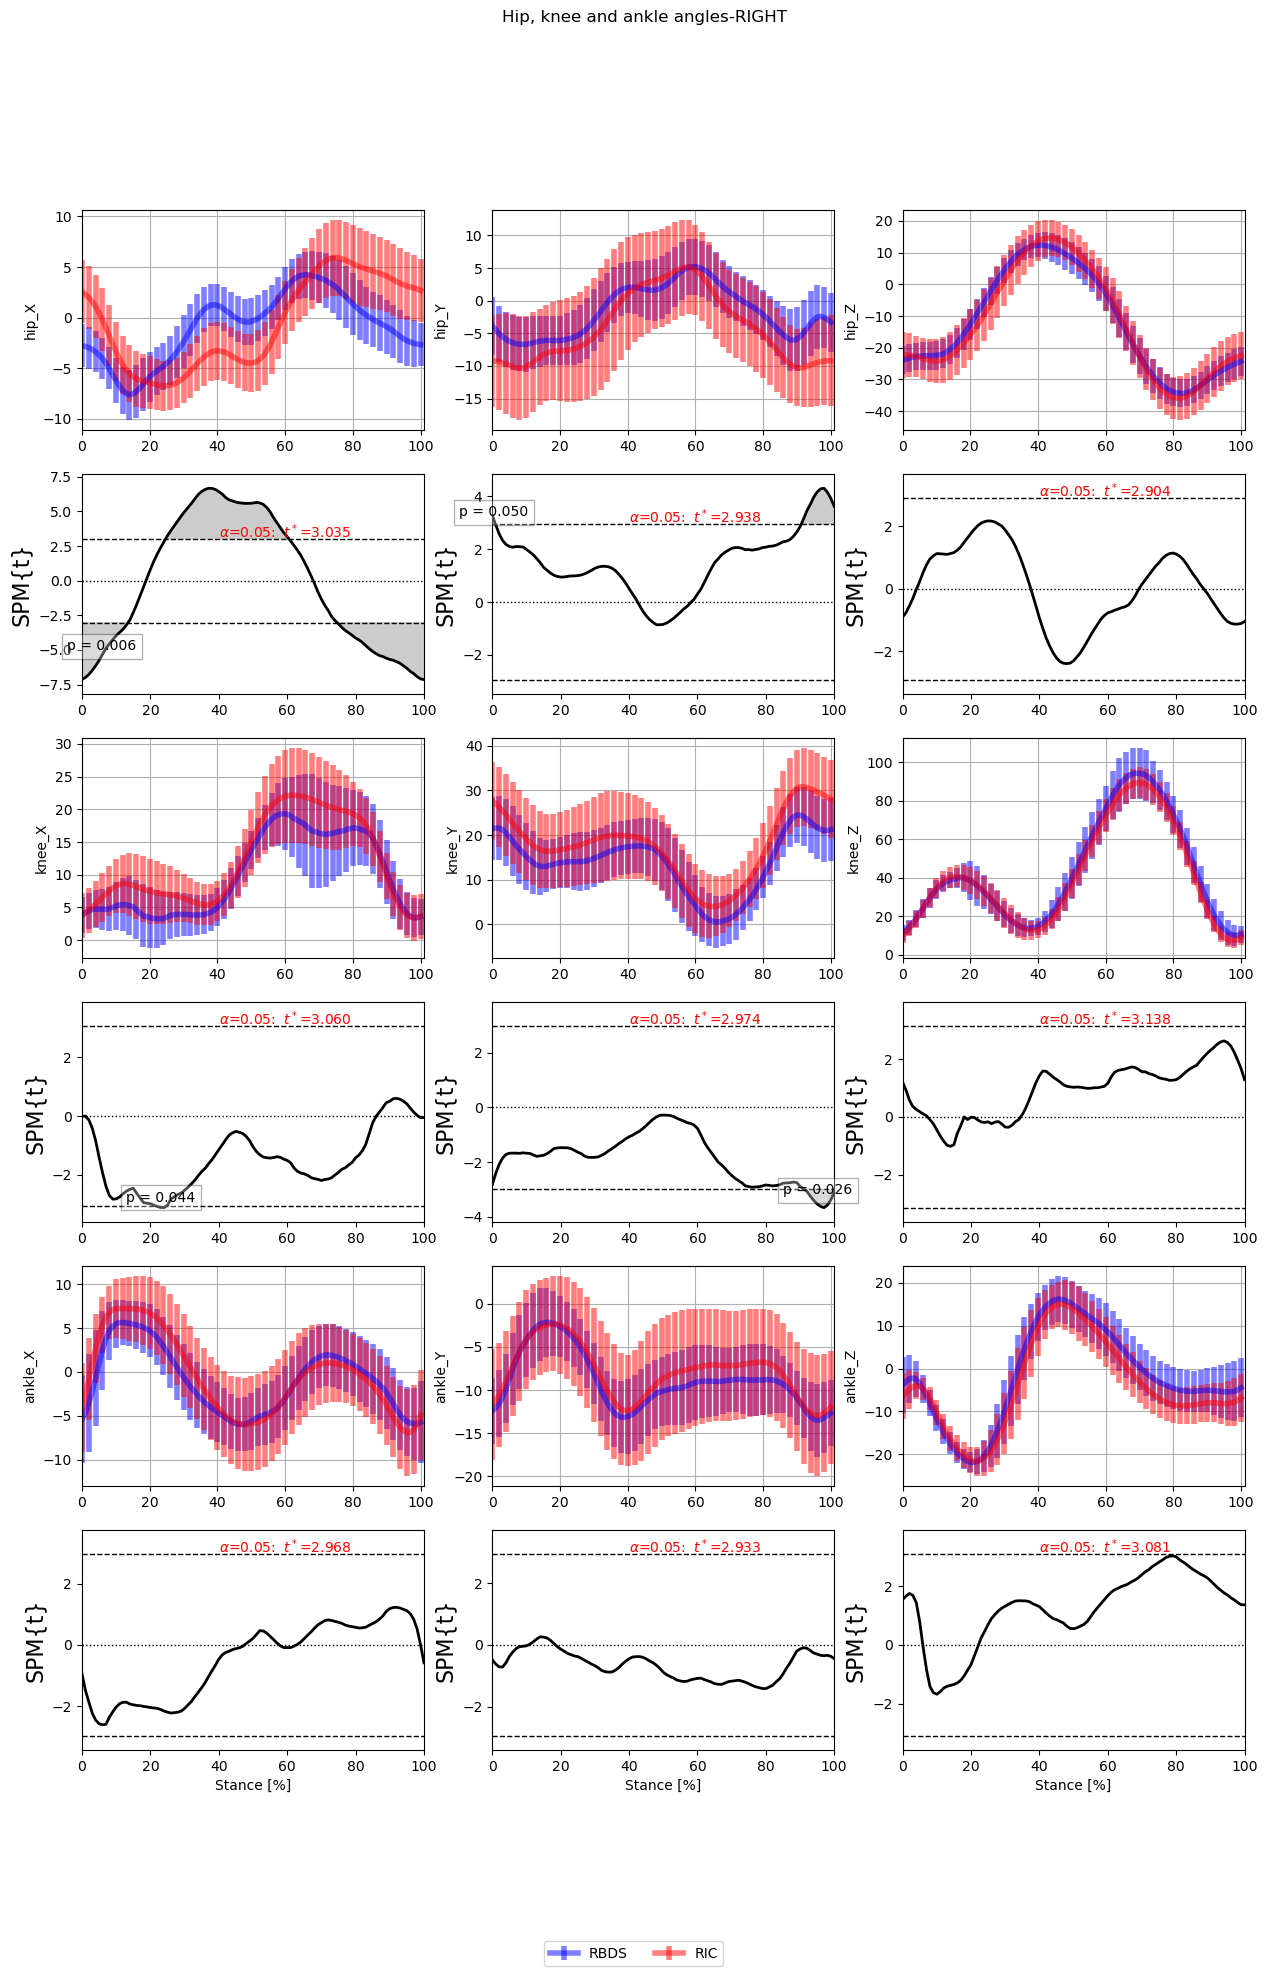

In [157]:
fig, axs = plt.subplots(6,3, figsize=(15,20))
fig.suptitle('Hip, knee and ankle angles-RIGHT')
for j, joint in enumerate(joints):
    for xyz, eixo in enumerate(axes):
        #axs[j,xyz].plot(tn,angsR3[:,3*j+xyz,:])
        axs[2*j,xyz].errorbar(tn,R_ang_RBDSme[:,3*j+xyz],R_ang_RBDSsd[:,3*j+xyz],
                           color = [0, 0, 1, 0.5], capsize=0, errorevery=2, lw=4)
        axs[2*j,xyz].errorbar(tn,R_ang_RICme[:,3*j+xyz],R_ang_RICsd[:,3*j+xyz],
                           color = [1, 0, 0, 0.5], capsize=0, errorevery=2, lw=4)
        axs[2*j,xyz].set_ylabel(joint+'_'+eixo)
        axs[2*j,xyz].set_xlim([0,101])
        axs[2*j,xyz].grid('on')
        
        # SPM calculation
        Ymen = R_ang_RBDS[:, 3*j+xyz, :]
        Yfem = R_ang_RIC[:, 3*j+xyz, :]
        t_j  = spm1d.stats.ttest2(Ymen.T, Yfem.T, 
                            equal_var=False)
        ti_j = t_j.inference(alpha=0.05, two_tailed=True, interp=True)
        ti_j.plot(ax=axs[2*j+1,xyz])
        ti_j.plot_threshold_label(ax=axs[2*j+1,xyz])
        ti_j.plot_p_values(ax=axs[2*j+1,xyz], size=10, offsets=[(0,0.3)])
        
        if j==2:
            axs[5,xyz].set_xlabel('Stance [%]')
fig.legend(['RBDS','RIC'], loc='lower center', ncol=2)
plt.show()

In [159]:
#fig.savefig(os.path.join(dir_data, 'SPM_compare_plot_.png'), bbox_inches='tight')

# PENDING
* CALCULATE RMSe
* WRITE PAPER

In [ ]:
fig, axs = plt.subplots(5,3, figsize=(10,6))
fig.suptitle('Pelvis, Foot, hip, knee and ankle angles-RIGHT')
for j, joint in enumerate(joints):
    for xyz, eixo in enumerate(axes):
        #axs[j,xyz].plot(tn,angsR3[:,3*j+xyz,:])
        axs[j,xyz].errorbar(tn,L_ang_RBDSme[:,3*j+xyz],L_ang_RBDSsd[:,3*j+xyz],
                           color = [0, 0, 1, 0.5], capsize=0, errorevery=2, lw=4)
        axs[j,xyz].errorbar(tn,L_ang_RICme[:,3*j+xyz],L_ang_RICsd[:,3*j+xyz],
                           color = [1, 0, 0, 0.5], capsize=0, errorevery=2, lw=4)
        axs[j,xyz].set_ylabel(joint+'_'+eixo)
        axs[j,xyz].grid('on')
fig.legend(['RBDS','RIC'], loc='lower center', ncol=2)
plt.show()

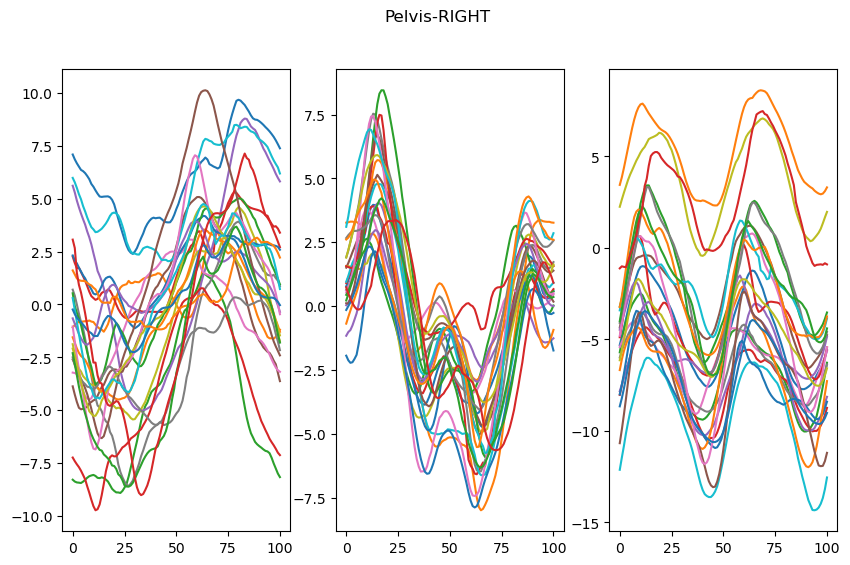

In [82]:
fig, axs = plt.subplots(1,3, figsize=(10,6))
fig.suptitle('Pelvis-RIGHT')
axs[0].plot(tn,angX[:,0,:])
axs[1].plot(tn,angX[:,1,:])
axs[2].plot(tn,angX[:,2,:])
#axs[0].grid('on')
#fig.legend(['RBDS','RIC'], loc='lower center', ncol=2)
plt.show()

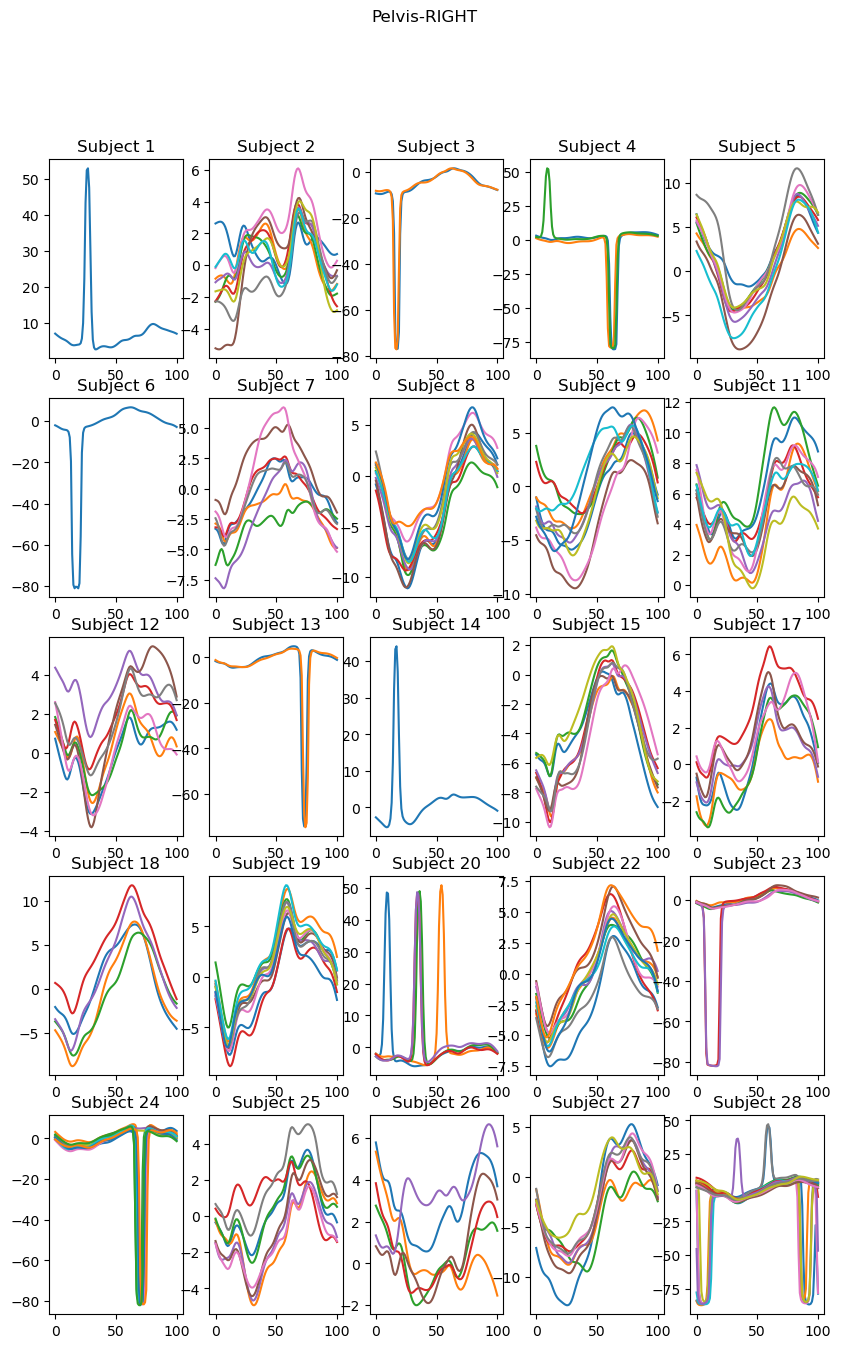

In [71]:
fig, axs = plt.subplots(5,5, figsize=(10,15))
fig.suptitle('Pelvis-RIGHT')
for i in range(5):
    for j in range(5):
        angs_temp_R = R_ang_RBDSall[:,:3,:,inds[5*i+j]]
        R_pelvis_ang= angs_temp_R[:,~np.isnan(angs_temp_R).all(axis=0)].reshape((101,3,-1))

        # Euclidean distance
        med_curve= np.median(R_pelvis_ang[:,0,:], axis=1)
        avgCurve = np.repeat(med_curve.reshape((1,101)),
                             R_pelvis_ang.shape[2], axis=0) # repeat avg curve
        dist = np.linalg.norm(R_pelvis_ang[:,0,:].T - avgCurve, axis=1) # Euclidean distance
        iMAXdist = np.argmax(dist) # index of max distance
        keep_ids = np.argwhere((dist>dist.mean()+dist.std()) | (dist<dist.mean()-dist.std())).flatten().tolist()

        # Plot all curves and outlier
        axs[i,j].set_title('Subject '+str(inds[5*i+j]+1))
        axs[i,j].plot(tn,R_pelvis_ang[:,0,keep_ids])
        #axs[i,j].plot(tn,np.median(R_pelvis_ang[:,0,:], axis=1),'*')
        #axs[i,j].plot(tn,R_pelvis_ang[:,0,iMAXdist],'o')

Subject 10, 16 and 21 should be removed as they have odd pelvic motion

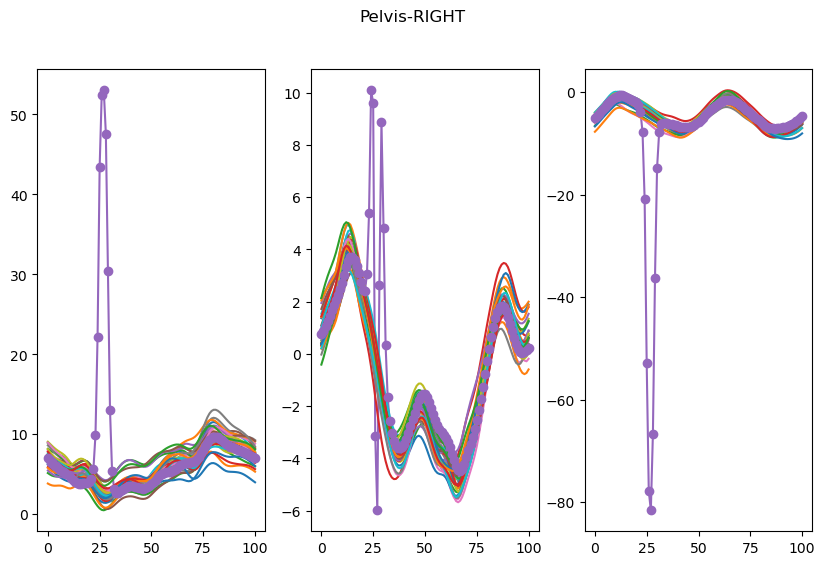

In [24]:
fig, axs = plt.subplots(1,3, figsize=(10,6))
fig.suptitle('Pelvis-RIGHT')
axs[0].plot(tn,R_pelvis_ang[:,0,:])
axs[0].plot(tn,R_pelvis_ang[:,0,iMAXdist],'o')
axs[1].plot(tn,R_pelvis_ang[:,1,:])
axs[1].plot(tn,R_pelvis_ang[:,1,iMAXdist],'o')
axs[2].plot(tn,R_pelvis_ang[:,2,:])
axs[2].plot(tn,R_pelvis_ang[:,2,iMAXdist],'o')
#axs[0].grid('on')
#fig.legend(['RBDS','RIC'], loc='lower center', ncol=2)
plt.show()

#### Add columns to help filter data

In [ ]:
# include column gait mode to label walk and run before merging
df_w['gait_mode']='walk'
df_r['gait_mode']='run'

In [ ]:
# Rename speed column
df_w.rename(columns={'speed_w': 'speed'}, inplace=True)
df_r.rename(columns={'speed_r': 'speed'}, inplace=True)

In [ ]:
# Merge walk and run dataframes
df = pd.concat([df_w, df_r], axis=0, ignore_index=True)
df.reset_index(drop=True, inplace=True)

In [ ]:
# Create Age group category
df['AgeGroup']=np.NaN
df.loc[df['age'] <= 49, "AgeGroup"] = "Young"
df.loc[df['age'] >= 50, "AgeGroup"] = "Older"

## Import data
### RBDS

In [ ]:
fnames = glob.glob(os.path.join(data_dir, 'RBDS*.c3d'))
fnames.sort()

Fix filenames string length because they do not have the pattern ***RBDSXXXstatic.c3d***

In [ ]:
# Find files
fnLESSstrings = [fn for fn in fnames if len(fn) < 73]
for fnL in fnLESSstrings:
    #os.rename(fnL, fnL[:-11]+'0'+fnL[-11:])
    print(fnL[:-11]+'0'+fnL[-11:])

In [ ]:
fnames_S = glob.glob(os.path.join(data_dir, 'RBDS*static.c3d'))
fnames_S.sort()

In [ ]:
fnames_R35 = glob.glob(os.path.join(data_dir, 'RBDS*runT35.c3d'))
fnames_R35.sort()

In [ ]:
import parse_gait_kinematics as parse_gait
from gait_kinematics import gait_kinematics
from gait_steps import gait_steps
from tnorma import tnorma

In [ ]:
# Create dataframe column corresponding to the dataset
joints_lbls = ['pelvis','L_foot','R_foot','L_hip','R_hip','L_knee','R_knee',
               'L_ankle','R_ankle']
xyz = list('XYZ')*len(joints_lbls)
joints_lbls = [ele for ele in joints_lbls for i in range(3)]
joints_lbls = [joints_lbls[i]+'_'+xyz[i] for i in range(len(xyz))]

## Batch process the files

In [ ]:
angs2 = np.empty(shape=(101,27,len(fnames_S)))
j = 0
for fn_static, fn_gait in zip(fnames_S,fnames_R35):
    neutral, joints, gait, hz = parse_gait.parse_RBDS(fn_static, fn_gait)

    # Invoking function to calculate angles
    angle_L_ankle, angle_R_ankle, angle_L_knee, angle_R_knee, angle_L_hip, angle_R_hip, angle_L_foot, angle_R_foot, angle_Pelvis = gait_kinematics(joints, neutral, gait, hz)
    # Convert to degrees
    angle_L_ankle, angle_R_ankle = angle_L_ankle*(180/np.pi), angle_R_ankle*(180/np.pi)
    angle_L_knee, angle_R_knee   = angle_L_knee*(180/np.pi), angle_R_knee*(180/np.pi)
    angle_L_hip, angle_R_hip     = angle_L_hip*(180/np.pi), angle_R_hip*(180/np.pi)
    angle_L_foot, angle_R_foot   = angle_L_foot*(180/np.pi), angle_R_foot*(180/np.pi)
    angle_Pelvis  = angle_Pelvis * (180/np.pi)
    # Create a pandas df with angles
    angs = np.hstack([angle_Pelvis, angle_L_foot, angle_R_foot, 
                      angle_L_hip, angle_R_hip, angle_L_knee, angle_R_knee, 
                      angle_L_ankle, angle_R_ankle])
    angles = pd.DataFrame(data=angs, columns=joints_lbls)

    # Get gait events
    L_TD, L_TO, R_TD, R_TO, eventsflag, label = gait_steps(neutral, gait, angles, hz)

    RTD, RTO = R_TD.astype(int).tolist(), R_TO.astype(int).tolist()
    LTD, LTO = L_TD.astype(int).tolist(), L_TO.astype(int).tolist()
    
    angs = np.empty(shape=(101,angles.shape[1],len(RTD)))
    for i in range(len(RTD)):
        angs[:,:,i], tn, indie = tnorma(angles.values[RTD[i]:RTO[i],:], k=1, smooth=0, 
                               mask=None, show=False)
    j+=1 # counter
    angs2[:,:,j-1] = np.nanmean(angs, axis=2)
    print(fn_static)

In [ ]:
angs2.shape

In [ ]:
ang_labels = angles.columns.tolist()

In [ ]:
varss = ['R_hip_X', 'R_hip_Y', 'R_hip_Z','R_knee_X', 'R_knee_Y', 'R_knee_Z',
         'R_ankle_X', 'R_ankle_Y', 'R_ankle_Z']

In [ ]:
inds = [ang_labels.index(v) for v in varss]

In [ ]:
angs3 = angs[:,inds,:]

In [ ]:
angs3.shape

### RIC

In [ ]:
# figshare_dir = r'C:\Users\Reginaldo\OneDrive - University of Calgary\data\Figshare_SciData\new_unzip'
# fn_json=os.path.join(figshare_dir, '201225', '20140515T133244.json')

# neutral_RIC, joints_RIC, gait_RIC, hz_RIC = parse_gait_kinematics.parse_RIC(fn_json)

In [ ]:
fig, axs = plt.subplots(3,3, figsize=(10,6))
fig.suptitle('Hip, knee and ankle angles')
for j, joint in enumerate(joints):
    ang = angles.filter(like='R_'+joint).values
    for xyz, eixo in enumerate(axes):
        for i in range(len(rtd)-1):
            axs[j,xyz].plot(ang[rtd[i]:rtd[i+1], xyz])
            axs[j,xyz].set_ylabel(joint+'_'+eixo)
            axs[j,xyz].grid('on')
plt.show()

In [ ]:
fig, axs = plt.subplots(3, figsize=(10,6))
fig.suptitle('Comparison of LEFT ankle angles between methods')
axs[0].plot(angle_L_ankle[:,0], 'b', label='Python')
axs[0].plot(tn[0::3],anga_matlab[0::3,0], 'b*', label='Matlab')
axs[0].grid('on')
axs[1].plot(angle_L_ankle[:,1], 'r', label='Python')
axs[1].plot(tn[0::3],anga_matlab[0::3,1], 'r*', label='Matlab')
axs[1].grid('on')
axs[2].plot(angle_L_ankle[:,2], 'g', label='Python')
axs[2].plot(tn[0::3],anga_matlab[0::3,2], 'g*', label='Matlab')
axs[2].grid('on')
plt.show()

In [ ]:
fig, axs = plt.subplots(3, figsize=(10,6))
fig.suptitle('Comparison of LEFT ankle angles between methods')
axs[0].plot(angle_L_ankle[:,0], 'b', label='Python')
axs[0].plot(tn[0::3],anga_matlab[0::3,0], 'b*', label='Matlab')
axs[0].grid('on')
axs[1].plot(angle_L_ankle[:,1], 'r', label='Python')
axs[1].plot(tn[0::3],anga_matlab[0::3,1], 'r*', label='Matlab')
axs[1].grid('on')
axs[2].plot(angle_L_ankle[:,2], 'g', label='Python')
axs[2].plot(tn[0::3],anga_matlab[0::3,2], 'g*', label='Matlab')
axs[2].grid('on')
plt.show()

# Visualize Markers
## RIC

In [ ]:
from mpl_toolkits.mplot3d import Axes3D

In [ ]:
# Average marker position
mkr_S = neutral_RIC.values.flatten()
# Marker labels list
mkr_S_lbl = [neutral_RIC.columns.tolist()[i][:-2] for i in range(mkr_S.shape[0])]
mkr_S_lbl_ = f7(mkr_S_lbl)

In [ ]:
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure(figsize=(8, 10))
ax = fig.add_subplot(111, projection='3d',  facecolor='white')
ax.view_init(90, -90, vertical_axis='z')


ax.scatter(mkr_S[0:-3:3], mkr_S[1:-2:3], mkr_S[2:-1:3], c='r', s=30, depthshade=False)
for m, mkr_lbl in enumerate(mkr_S_lbl_):
    ax.text(mkr_S[3*m], mkr_S[3*m+1], mkr_S[3*m+2], mkr_lbl)

ax.set_xlim3d([np.nanmin(mkr_S[0::3])-.4, np.nanmax(mkr_S[0::3])+.4])
ax.set_ylim3d([np.nanmin(mkr_S[1::3])-.4, np.nanmax(mkr_S[1::3])+.4])
ax.set_zlim3d([np.nanmin(mkr_S[2::3]), np.nanmax(mkr_S[2::3])])
ax.set_xlabel('\n' + 'X [m]', linespacing=2)
ax.set_ylabel('\n' + 'Y [m]', linespacing=2)
ax.set_zlabel('\n' + 'Z [m]', linespacing=2)
#ax.invert_yaxis()
# square plot
ax.set_aspect('equal', adjustable='box')
plt.show()

## RBDS

In [ ]:
# Average marker position
mkr_S = neutral.values.flatten()
# Marker labels list
mkr_S_lbl = [neutral.columns.tolist()[i][:-2] for i in range(mkr_S.shape[0])]
mkr_S_lbl_ = f7(mkr_S_lbl)

In [ ]:
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure(figsize=(8, 10))
ax = fig.add_subplot(111, projection='3d',  facecolor='white')
ax.view_init(90, -90, vertical_axis='z')


ax.scatter(mkr_S[0:-3:3], mkr_S[1:-2:3], mkr_S[2:-1:3], c='r', s=30, depthshade=False)
for m, mkr_lbl in enumerate(mkr_S_lbl_):
    ax.text(mkr_S[3*m], mkr_S[3*m+1], mkr_S[3*m+2], mkr_lbl)

ax.set_xlim3d([np.nanmin(mkr_S[0::3])-.4, np.nanmax(mkr_S[0::3])+.4])
ax.set_ylim3d([np.nanmin(mkr_S[1::3])-.4, np.nanmax(mkr_S[1::3])+.4])
ax.set_zlim3d([np.nanmin(mkr_S[2::3]), np.nanmax(mkr_S[2::3])])
ax.set_xlabel('\n' + 'X [m]', linespacing=2)
ax.set_ylabel('\n' + 'Y [m]', linespacing=2)
ax.set_zlabel('\n' + 'Z [m]', linespacing=2)
#ax.invert_yaxis()
# square plot
ax.set_aspect('equal', adjustable='box')
plt.show()

# Script used to write gait_steps.py
Leave in the bottom of the NB in case I need to troubleshoot later.

In [ ]:
## Prepare environment
# import os, sys
# import numpy as np
# import pandas as pd
# #from scipy import signal
# import scipy.io as spio
# import matlab
# import matlab.engine

# from detecta import detect_peaks
# from pca_td import pca_td
# from pca_to import pca_to

# from scipy.signal import butter, lfilter, filtfilt
# from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

# INPUT PARAMS
# hz = data_RIC['hz_r']
# neutral
# angles
# label
# pathname = r'../data'# Import data

#%% Determine functional measures and gait type (walk vs run)
# % movement speed comes from the A/P position time history of a heel marker
# % so we first need to identify a heel marker
# LEFT SIDE
# Determine functional measures and gait type (walk vs run) movement speed comes 
# from the A/P position time history of a heel marker so we first need to identify 
# a heel marker.

# % Combine 3 of the foot markers into one matrix (ignore the created fourth)
L_foot = neutral[['L_foot_1_X', 'L_foot_1_Y', 'L_foot_1_Z',
              'L_foot_2_X', 'L_foot_2_Y', 'L_foot_2_Z',
              'L_foot_3_X', 'L_foot_3_Y', 'L_foot_3_Z']].values.reshape((3,3))
# sort the markers from left to right
i_lf   = list(L_foot[:, 0].argsort())
L_foot = L_foot[L_foot[:, 0].argsort()]

# find the lower of the two medial markers
if L_foot[1,1] < L_foot[2,1]:
    L_marker = 'L_foot_' + str(i_lf[1]+1)
    L_heel =  gait.filter(like=L_marker).values
else:
    L_marker = 'L_foot_' + str(i_lf[2]+1)
    L_heel =  gait.filter(like=L_marker).values
    
# Find peaks location. Signal flipped because of X-axis convention difference.
locs0 = detect_peaks(np.diff(L_heel[:,2]), mpd=np.round(0.5*hz), 
                    mph=0, show=False)
pks = np.diff(L_heel[:,2])[locs0]

locs = detect_peaks(-np.diff(L_heel[:,2]), mpd=np.round(0.5*hz), 
                    mph=0, show=False)

# Gait velocity and cadence
vel    = hz*np.median(pks)/1000; # gait speed
stRate = 60/(np.median(np.diff(locs))/hz); # cadence
#print('Gait velocity is '+str(vel)+' m/s')
#print('Stride rate is '+str(stRate)+' strides/min')

#%% RIGHT SIDE
# % Combine 3 of the foot markers into one matrix (ignore the created fourth)
R_foot = neutral[['R_foot_1_X', 'R_foot_1_Y', 'R_foot_1_Z',
              'R_foot_2_X', 'R_foot_2_Y', 'R_foot_2_Z',
              'R_foot_3_X', 'R_foot_3_Y', 'R_foot_3_Z']].values.reshape((3,3))
# sort the markers from left to right
i_rf   = list(R_foot[:, 0].argsort())
R_foot = R_foot[R_foot[:, 0].argsort()]

# find the lower of the two medial markers
if R_foot[0,1] < R_foot[1,1]:
    R_marker = 'R_foot_' + str(i_rf[0]+1)
    R_heel =  gait.filter(like=R_marker).values
else:
    R_marker = 'R_foot_' + str(i_rf[1]+1)
    R_heel =  gait.filter(like=R_marker).values
    
# Linear discriminant analysis
# Import training dataset
gaitClass = pd.read_csv(os.path.join(r'../data', 'LDA_out.txt'), delimiter='\t', 
                        header=None, names=['Category','Speed','Cadence'], usecols=[0,1,2])
# Replace numerical by categorical
gaitClass['Category'] = gaitClass['Category'].replace(1, 'walk')
gaitClass['Category'] = gaitClass['Category'].replace(2, 'run')

# Input to the model
X = gaitClass[['Speed','Cadence']].values # training data
y = gaitClass['Category'].values.tolist() # testing data
model = LinearDiscriminantAnalysis()# define model
model.fit(X, y) # Model fit

# make a prediction
label = model.predict(np.array([vel,stRate]).reshape((1,2)))[0]
#print('Gait category is '+label)

# Load PCA output from mat file
# % event_data is a .mat file containing 'coeff' which is the coefficients
# % from the pre-trained PCA and 'p' which is the list of coefficients of the
# % linear polynomial relating PCA scores with touchdown timing relative to
# % the foot acceleration peak.
event_data_TD = spio.loadmat(os.path.join(r'../data', 'event_data_TD.mat'))
event_data_TO = spio.loadmat(os.path.join(r'../data', 'event_data_TO.mat'))

#%% Identify Touch Down and Take Off events: Gait Independent
# % Use PCA touchdown detection based on updated Osis et al. (2014) for
# % both walking and running.
# % Use new PCA toeoff detection for both walking and running.
# % evt variables are NOT rounded
try:
    evtLtd, evtRtd = pca_td(angles, hz, event_data_TD, label)
    evtLto, evtRto = pca_to(angles, hz, event_data_TO, label)
    
except Exception as e: 
    #For a small number of people, these functions return errors, or in the
    #case of bad data... default to use FF and FB in these cases
    
    evtRtd = []
    evtRto = []
    
    print('Automated event detection failed, defaulting to foot-forward foot-back')
    print(e)
    
## LEFT FOOT EVENTS
# % when the feet are not tracked very well, discontinuities in the heel
# % marker can occur causing the findpeaks to pick up additional 'peaks'
# % for the purposes of simply identifying foot forward and foot back
# % timing, we can over filter this signal. We do not care about the
# % magnitude of the signal but only the timing so we can overfit as long
# % as the filter has a zero phase shift.
# % Note: signal is now filtered by default.  There is no advantage to not
# % filtering, as if the signal quality is already good, then the system uses
# % PCA event detection anyhow, and if the signal is bad, then it has to be
# % filtered in order to get foot-forward foot-backward events.

# Correct the cutoff frequency for the number of passes in the filter
b, a = butter(2, 5/(hz/2), btype = 'low')
# note that Python and Matlab filtfilt behaves slightly different with padding the data
# see https://mail.python.org/pipermail/scipy-user/2014-April/035646.html
filtered_L_heel = filtfilt(b, a, L_heel[:,2], padtype='odd')

# Begin by creating a gross estimation of foot forwards and foot backs
L_FFi = detect_peaks(-filtered_L_heel, mpd=np.round(0.35*hz),
                     show=False)

if label == 'walk':
    # % Use peak foot flexion angle for foot back
    # % To deal with peaks resulting from signal flipping, threshold them
    angSig = angles['L_foot_Z'].values
    angSig[np.abs(angSig) > 90] = np.NaN
    L_FBi = detect_peaks(-angSig, mpd=np.round(0.7*hz),
                     mph=20, show=False)
else:
    # Use rearmost position of heel marker for foot back
    L_FBi = detect_peaks(filtered_L_heel, mpd=np.round(0.35*hz),
                     show=False)
    
# %Uncomment block below to enable more aggressive quality control of data

# if (np.nanpercentile(np.abs(angles['foot_Z'].values), 90) > 120) & vel < 4
#     print('Right ankle values outside of expected ranges, please ensure your shoe markers are properly placed and redo your collection')
#     sys.exit()

# Remove any leading FB
L_FBi = L_FBi[L_FBi>L_FFi[0]]

## find largest chunk of continuous data

#We want to check before and after that there is sufficient data for analysis

if (L_FFi.shape[0] < 2) or (L_FBi.shape[0] < 2):
    print('Automated event detection unable to pull adequate number of strides for analysis. Please redo your data collection.')
    sys.exit()
    
# Call Matlab function LARGEST_BLOCK.m from Python
eng = matlab.engine.start_matlab() # start Matlab engine
eng.cd(r'../functions', nargout=0) # set path for functions dir


L_FFi, L_FBi, L_block_start, block_end = eng.largest_block(matlab.double(list(L_FFi)), 
                                                             matlab.double(list(L_FBi)), nargout=4)

L_FFi = np.array(L_FFi).flatten().astype(int)
L_FBi = np.array(L_FBi).flatten().astype(int)

if (L_FFi.shape[0] < 2) or (L_FBi.shape[0] < 2):
    print('Automated event detection unable to pull adequate number of strides for analysis. Please redo your data collection.')
    sys.exit()
    
# TOUCHDOWN
# evtLtd from above

# SELECT SEQUENTIAL STEPS
# create an ordered set of sequential steps using FFi as guide
closest = np.abs(np.repeat(L_FFi[:,np.newaxis], evtLtd.shape[0], axis=1)-np.repeat(evtLtd[:,np.newaxis].T, L_FFi.shape[0], axis=0))

mindist, minx = np.nanmin(closest, axis=0), np.nanargmin(closest, axis=0)

for i in np.unique(minx).astype(int):
    if np.sum(np.isin(i,minx)) > 1:
        mindist = mindist[minx!=i]
        evtLtd  = evtLtd[minx!=i]
        minx    = minx[minx!=i]
        
# Parameter based on the typical frame adjustments observed in 300
# datasets
if label=='run':
    maxadj = 0.05*hz
else:
    maxadj = 0.10*hz
    
# Preallocate
L_TD = np.empty(L_FFi.shape[0]) * np.NaN
evFltd = np.zeros(L_FFi.shape[0])

# Here we replace FF indices with indices from evt where criteria are
# met... the default is to use FF
for i in range(L_FFi.shape[0]):
    try:
        if i > np.max(minx):
            break
        elif np.isin(i,minx) and mindist[minx==i] < maxadj:
            #Replace with evtLtd since its more accurate
            L_TD[i] = evtLtd[minx==i]
            evFltd[i] = 1
        else:
            #Use FFi since it is more robust
            L_TD[i] = L_FFi[i]
            
    except Exception as e:
        print(e)
        L_TD[i] = L_FFi[i]
        
# %% TAKEOFF

# % evtLto from above

# % SELECT SEQUENTIAL STEPS

# % Now create an ordered set of sequential steps using FBi as guide
closest = np.abs(np.repeat(L_FBi[:,np.newaxis], evtLto.shape[0], axis=1)-np.repeat(evtLto[:,np.newaxis].T, L_FBi.shape[0], axis=0))

mindist, minx = np.nanmin(closest, axis=0), np.nanargmin(closest, axis=0)
for i in np.unique(minx).astype(int):
    if np.sum(np.isin(i,minx)) > 1:
        mindist = mindist[minx!=i]
        evtLtd  = evtLtd[minx!=i]
        minx    = minx[minx!=i]
        
# Parameter based on the frame adjustment observed from 300 datasets
maxadj = 0.15*hz

# Preallocate
L_TO = np.empty(L_FBi.shape[0]) * np.NaN
evFlto = np.zeros(L_FBi.shape[0])

# Here we replace FB indices with TO from PCA default is to use FB
for i in range(L_FBi.shape[0]):
    try:
        if i > np.max(minx):
            break
        elif np.isin(i,minx) and mindist[minx==i] < maxadj:
            #Replace with evtLto since its more accurate
            L_TO[i] = evtLto[minx==i]
            evFlto[i] = 1
        else:
            #Use FFi since it is more robust
            L_TO[i] = L_FBi[i]
            
    except Exception as e:
        print(e)
        L_TO[i] = L_FBi[i]

# Finally we round to get final indices
L_TD = L_TD.round()
L_TO = L_TO.round()


# %% RIGHT FOOT EVENTS
# % the same steps we just took for the left side

# % Begin by creating a gross estimation of foot forwards and foot backs
# Correct the cutoff frequency for the number of passes in the filter
b, a = butter(2, 5/(hz/2), btype = 'low')
# note that Python and Matlab filtfilt behaves slightly different with padding the data
# see https://mail.python.org/pipermail/scipy-user/2014-April/035646.html
filtered_R_heel = filtfilt(b, a, R_heel[:,2], padtype='odd')

# Begin by creating a gross estimation of foot forwards and foot backs
R_FFi = detect_peaks(-filtered_R_heel, mpd=np.round(0.35*hz),
                     show=False)

if label == 'walk':
    # % Use peak foot flexion angle for foot back
    # % To deal with peaks resulting from signal flipping, threshold them
    angSig = angles['R_foot_Z'].values
    angSig[np.abs(angSig) > 90] = np.NaN
    R_FBi = detect_peaks(-angSig, mpd=np.round(0.7*hz),
                     mph=20, show=False)
else:
    # Use rearmost position of heel marker for foot back
    R_FBi = detect_peaks(filtered_R_heel, mpd=np.round(0.35*hz),
                     show=False)
    
# %Uncomment block below to enable more aggressive quality control of data

# if (np.nanpercentile(np.abs(angles['R_foot_Z'].values), 90) > 120) & vel < 4
#     print('Right ankle values outside of expected ranges, please ensure your shoe markers are properly placed and redo your collection')
#     sys.exit()

# Remove any leading FB
R_FFi = R_FFi[R_FFi>L_FFi[0]]
R_FBi = R_FBi[R_FBi>R_FFi[0]]

## find largest chunk of continuous data

#We want to check before and after that there is sufficient data for analysis

if (R_FFi.shape[0] < 2) or (R_FBi.shape[0] < 2):
    print('Automated event detection unable to pull adequate number of strides for analysis. Please redo your data collection.')
    sys.exit()
    
    
# LARGEST_BLOCK
R_FFi, R_FBi, R_block_start, R_block_end = eng.largest_block(matlab.double(list(R_FFi)), 
                                                             matlab.double(list(R_FBi)), nargout=4)

R_FFi = np.array(R_FFi).flatten().astype(int)
R_FBi = np.array(R_FBi).flatten().astype(int)

if (R_FFi.shape[0] < 2) or (R_FBi.shape[0] < 2):
    print('Automated event detection unable to pull adequate number of strides for analysis. Please redo your data collection.')
    sys.exit()
    
# %In rare instances a the index will be in incorrect order run below again
# %in case

# % Remove any leading FF and FB
R_FFi = R_FFi[R_FFi>L_FFi[0]]
R_FBi = R_FBi[R_FBi>R_FFi[0]]

# TOUCHDOWN
# evtRtd from above

# SELECT SEQUENTIAL STEPS
# create an ordered set of sequential steps using FFi as guide
closest = np.abs(np.repeat(R_FFi[:,np.newaxis], evtRtd.shape[0], axis=1)-np.repeat(evtRtd[:,np.newaxis].T, R_FFi.shape[0], axis=0))

mindist, minx = np.nanmin(closest, axis=0), np.nanargmin(closest, axis=0)

for i in np.unique(minx).astype(int):
    if np.sum(np.isin(i,minx)) > 1:
        mindist = mindist[minx!=i]
        evtLtd  = evtLtd[minx!=i]
        minx    = minx[minx!=i]
        
# Parameter based on the typical frame adjustments observed in 300
# datasets
if label=='run':
    maxadj = 0.05*hz
else:
    maxadj = 0.10*hz
    
# Preallocate
R_TD = np.empty(R_FFi.shape[0]) * np.NaN
evFrtd = np.zeros(R_FFi.shape[0])

# Here we replace FF indices with indices from evt where criteria are
# met... the default is to use FF
for i in range(R_FFi.shape[0]):
    try:
        if i > np.max(minx):
            break
        elif np.isin(i,minx) and mindist[minx==i] < maxadj:
            #Replace with evtRtd since its more accurate
            R_TD[i] = evtRtd[minx==i]
            evFrtd[i] = 1
        else:
            #Use FFi since it is more robust
            R_TD[i] = R_FFi[i]
            
    except Exception as e:
        print(e)
        R_TD[i] = R_FFi[i]
        
        
# %% TAKEOFF

# % evtRto from above

# % SELECT SEQUENTIAL STEPS

# % Now create an ordered set of sequential steps using FBi as guide
closest = np.abs(np.repeat(R_FBi[:,np.newaxis], evtRto.shape[0], axis=1)-np.repeat(evtRto[:,np.newaxis].T, R_FBi.shape[0], axis=0))

mindist, minx = np.nanmin(closest, axis=0), np.nanargmin(closest, axis=0)
for i in np.unique(minx).astype(int):
    if np.sum(np.isin(i,minx)) > 1:
        mindist = mindist[minx!=i]
        evtLtd  = evtLtd[minx!=i]
        minx    = minx[minx!=i]
        
# Parameter based on the frame adjustment observed from 300 datasets
maxadj = 0.15*hz

# Preallocate
R_TO = np.empty(R_FBi.shape[0]) * np.NaN
evFrto = np.zeros(R_FBi.shape[0])

# Here we replace FB indices with TO from PCA default is to use FB
for i in range(R_FBi.shape[0]):
    try:
        if i > np.max(minx):
            break
        elif np.isin(i,minx) and mindist[minx==i] < maxadj:
            #Replace with evtLto since its more accurate
            R_TO[i] = evtRto[minx==i]
            evFrto[i] = 1
        else:
            #Use FFi since it is more robust
            R_TO[i] = R_FBi[i]
            
    except Exception as e:
        print(e)
        R_TO[i] = R_FBi[i]

# Finally we round to get final indices
R_TD = R_TD.round()
R_TO = R_TO.round()

# %% if largest chunk of continuous data not at beginning, chop both right and left so they match


# %index must begin with left touchdown and end with right toe
# %off


if R_block_start < L_block_start:
    #remove all right indices that occur before the first left touchdown
    
    R_TO = R_TO[(R_TD < L_block_start)!=1]
    R_TD = R_TD[(R_TD < L_block_start)!=1]
    
flag = 0

if L_block_start < R_block_start:
    #remove left touchdowns more than one touchdown before the first right touchdown
    cut_inds = (L_TD<R_block_start)==1
    cut_inds.astype(int)
    #this loop ensures the first index will be a left touchdown
    for i in range(cut_inds.shape[0]):
        if (cut_inds[i]==1) and (cut_inds[i+1]==0) and flag==0:
            cut_inds[i] = 0
            flag = 1
            
    L_TD = np.delete(L_TD, cut_inds)
    L_TO = np.delete(L_TO, cut_inds)
    
    
# create an events matrix
# Remove trailing nans that may have crept in
evFltd = evFltd[~np.isnan(L_TD)]
evFlto = evFlto[~np.isnan(L_TO)]
evFrtd = evFrtd[~np.isnan(R_TD)]
evFrto = evFrto[~np.isnan(R_TO)]

L_TD = L_TD[~np.isnan(L_TD)]
L_TO = L_TO[~np.isnan(L_TO)]
R_TD = R_TD[~np.isnan(R_TD)]
R_TO = R_TO[~np.isnan(R_TO)]

# Find the closest ordered pairs of L_TO and R_TD to synchronize steps
closest = np.abs(np.repeat(R_TD[:,np.newaxis], L_TO.shape[0], axis=1)-np.repeat(L_TO[:,np.newaxis].T, R_TD.shape[0], axis=0))

minx = np.nanargmin(closest,axis=0)

#Truncate right stances to match up with left
evFrtd = evFrtd[np.unique(minx)]
R_TD = R_TD[np.unique(minx)]


testlength = np.min([L_TO.shape[0], R_TD.shape[0]])
if np.median(L_TO[:testlength]-R_TD[:testlength]) < 0:#Then there is a flight phase
    #Find the closest ordered pairs of R_TD and R_TO to synchronize steps
    closest = np.abs(np.repeat(R_TO[:,np.newaxis], R_TD.shape[0], axis=1)-np.repeat(R_TD[:,np.newaxis].T, R_TO.shape[0], axis=0))
    minx = np.nanargmin(closest,axis=0)
    
else: # There is no flight phase i.e. grounded running or walking
    #Find the closest ordered pairs of R_TO and L_TD to synchronize steps
    tmp = L_TD[1:]
    closest = np.abs(np.repeat(R_TO[:,np.newaxis], tmp.shape[0], 
                               axis=1)-np.repeat(tmp[:,np.newaxis].T, R_TO.shape[0], axis=0))
    minx = np.nanargmin(closest,axis=0)
    
evFrto = evFrto[np.unique(minx)]
R_TO = R_TO[np.unique(minx)]

events = [L_TD.shape[0], L_TO.shape[0], R_TD.shape[0], R_TO.shape[0]]

# Chop everything to the same length
L_TD = L_TD[:min(events)]
L_TO = L_TO[:min(events)]
R_TD = R_TD[:min(events)]
R_TO = R_TO[:min(events)]

evFltd = evFltd[:min(events)]
evFlto = evFlto[:min(events)]
evFrtd = evFrtd[:min(events)]
evFrto = evFrto[:min(events)]

# Very rarely, these will wind up empty and assignment doesn't work
events = np.empty(shape=(L_TD.shape[0],4)) * np.NaN
events[:,0]=L_TD
events[:,1]=L_TO
events[:,2]=R_TD
events[:,3]=R_TO
# Very rarely, these will wind up empty and assignment doesn't work
eventsflag = np.empty(shape=(evFltd.shape[0],4)) * np.NaN
eventsflag[:,0]=evFltd
eventsflag[:,1]=evFlto
eventsflag[:,2]=evFrtd
eventsflag[:,3]=evFrto

# Remove first row since these will very often be reliant on FF and FB measures
if events.shape[0] > 1:
    events = np.delete(events,0,axis=0)
    eventsflag = np.delete(eventsflag,0,axis=0)
    
# %% Occasionally, one stance will drop out, and data becomes
# % discontinuous...this fix alleviates this by trimming data to largest
# % continuous block
try:
    cont = np.array([events[1:,0]>events[:-1,1],events[1:,2]>events[:-1,3]])
    cont = np.hstack((np.zeros((2,1)),cont,np.zeros((2,1)))).T
    F = np.where(np.any(cont==0, axis=1))
    F = np.asarray(F).flatten()
    D = np.diff(F)-2
    M, L = np.max(D), np.argmax(D)
    events = events[F[L]:F[L]+M+1,:]
    eventsflag = eventsflag[F[L]:F[L]+M+1,:]
except Exception as e:
    print('Could not obtain a continuous block of events')
    events = []
    eventsflag = []
    print(e)
    
# Worst-case... return to foot forward, foot back detection
if events.shape[0] < 5:
    print('Automated event detection failed, defaulting to foot-forward foot-back')
    nevents = [L_FFi.shape[0], L_FBi.shape[0], R_FFi.shape[0], R_FBi.shape[0]]
    
    # Chop everything to the same length
    L_FFi = L_FFi[:min(nevents)]
    L_FBi = L_FBi[:min(nevents)]
    R_FFi = R_FFi[:min(nevents)]
    R_FBi = R_FBi[:min(nevents)]
    
    events = np.empty(shape=(min(nevents),4)) * np.NaN
    events[:,0] = L_FFi
    events[:,1] = L_FBi
    events[:,2] = R_FFi
    events[:,3] = R_FBi
    
# Pull event columns from events so everything is consistent
L_TD = events[:,0]
L_TO = events[:,1]
R_TD = events[:,2]
R_TO = events[:,3]

In [ ]:
L_TD

In [ ]:
L_TDm

In [ ]:
L_TO

In [ ]:
L_TOm

In [ ]:
R_TD

In [ ]:
R_TDm

## Compare outputs between gait_steps.m and gait_steps.py

In [ ]:
# Invoking function to calculate angles
#angle_L_ankle, angle_R_ankle, angle_L_knee, angle_R_knee, angle_L_hip, angle_R_hip, angle_L_foot, angle_R_foot, angle_Pelvis = gait_kinematics(joints, neutral, gait, data_RIC['hz_r'])

In [ ]:
'L_ankle','R_ankle','L_knee','R_knee','L_hip','R_hip','L_foot','R_foot','pelvis'

In [ ]:
angles_dict = dict()
angles_dict['L_ankle'] = angle_L_ankle
angles_dict['R_ankle'] = angle_R_ankle
angles_dict['L_knee']  = angle_L_knee
angles_dict['R_knee']  = angle_R_knee
angles_dict['L_hip']   = angle_L_hip
angles_dict['R_hip']   = angle_R_hip
angles_dict['L_foot']  = angle_L_foot
angles_dict['R_foot']  = angle_R_foot
angles_dict['pelvis']  = angle_Pelvis

In [ ]:
data_RIC['hz_r']

In [ ]:
matlab.double(float(data_RIC['hz_r']))

In [ ]:
# Call Matlab function gait_steps.m from Python
norm_ang, norm_vel, events, event, dvs, vel, eventsflag, label = eng.gait_steps(data_RIC['neutral'], 
                                                        data_RIC['running'], 
                                                        angles_dict, angles_dict,
                                                        data_RIC['hz_r'],0,
                                                        nargout=8)

In [ ]:
#[norm_ang,norm_vel,events,event,DISCRETE_VARIABLES,speedoutput,eventsflag,label] = gait_steps(neutral,dynamic,angles,velocities,hz,plots)